## 1. 라이브러리 불러오기

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 그래프가 노트북 안에 바로 그려지게 하는 매직 커맨드
%matplotlib inline 

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


## 2. 데이터 불러오기

In [17]:
# [수정된 두 번째 셀]
file_path = 'Radar_Denoising/sine_dataset.mat'

try:
    with h5py.File(file_path, 'r') as f:
        print(f"변수 목록: {list(f.keys())}")
        
        # 1. 일단 raw 데이터로 읽어옵니다. (Transpose .T 적용)
        X_raw = np.array(f['X_noisy']).T
        Y_raw = np.array(f['Y_clean']).T
        SNR_log = np.array(f['SNR_log']).T
        
        # 2. 구조체 형태인지 확인하고, 진짜 복소수(Complex)로 변환합니다.
        # MATLAB v7.3은 복소수를 ('real', 'imag') 필드를 가진 구조체로 저장합니다.
        
        # X_noisy 변환
        if X_raw.dtype.names is not None and 'real' in X_raw.dtype.names:
            X_noisy = X_raw['real'] + 1j * X_raw['imag']
        else:
            X_noisy = X_raw # 이미 복소수라면 그대로 사용

        # Y_clean 변환
        if Y_raw.dtype.names is not None and 'real' in Y_raw.dtype.names:
            Y_clean = Y_raw['real'] + 1j * Y_raw['imag']
        else:
            Y_clean = Y_raw

    print("\n데이터 로드 및 복소수 변환 성공!")
    print(f"X_noisy shape: {X_noisy.shape}")
    print(f"X_noisy type: {X_noisy.dtype}") # complex128 이라고 나오면 성공!
    
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"에러 발생: {e}")

변수 목록: ['SNR_log', 'X_noisy', 'Y_clean']

데이터 로드 및 복소수 변환 성공!
X_noisy shape: (5000, 1024)
X_noisy type: complex128


## 3. 시각화 (그래프 그리기)

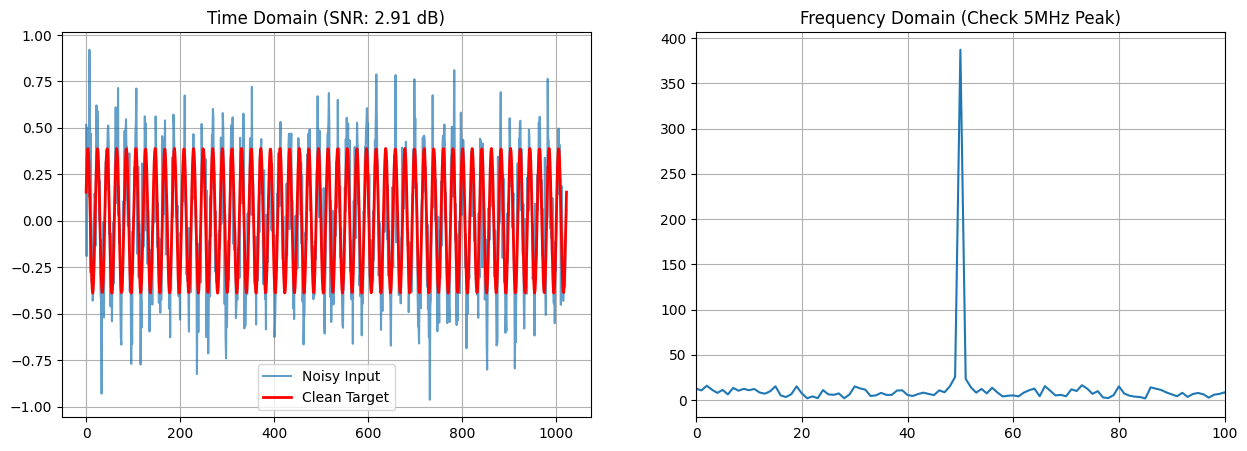

In [18]:
idx = 0 # 확인하고 싶은 데이터 번호 (0 ~ 4999)

plt.figure(figsize=(15, 5))

# 1. 시간 영역 (Time Domain)
plt.subplot(1, 2, 1)
plt.plot(np.real(X_noisy[idx]), label='Noisy Input', alpha=0.7)
plt.plot(np.real(Y_clean[idx]), 'r', label='Clean Target', linewidth=2)
plt.title(f'Time Domain (SNR: {SNR_log[idx][0]:.2f} dB)')
plt.legend()
plt.grid(True)

# 2. 주파수 영역 (Frequency Domain)
plt.subplot(1, 2, 2)
# FFT 계산
fft_data = np.abs(np.fft.fft(X_noisy[idx]))
# 주파수 축 생성 (대략적인 인덱스로 표현)
plt.plot(fft_data)
plt.title('Frequency Domain (Check 5MHz Peak)')
plt.xlim(0, 100) # 앞부분 확대
plt.grid(True)

plt.show()

## 4. RadarDataset 클래스 정의

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

class RadarDataset(Dataset):
    def __init__(self, mat_file_path):
        """
        mat_file_path: .mat 파일의 경로
        """
        self.file_path = mat_file_path
        
        # 데이터 로드 (메모리에 올리기)
        with h5py.File(self.file_path, 'r') as f:
            # 1. 데이터 읽기 및 전치 (.T) -> (N, Length)
            X_raw = np.array(f['X_noisy']).T
            Y_raw = np.array(f['Y_clean']).T
            
            # 2. 복소수 변환 (구조체 -> complex128)
            # MATLAB v7.3 이슈 해결 코드
            if X_raw.dtype.names is not None and 'real' in X_raw.dtype.names:
                self.X_data = X_raw['real'] + 1j * X_raw['imag']
                self.Y_data = Y_raw['real'] + 1j * Y_raw['imag']
            else:
                self.X_data = X_raw
                self.Y_data = Y_raw
                
        print(f"데이터셋 로드 완료: {len(self.X_data)} 샘플")

    def __len__(self):
        # 데이터의 총 개수 반환
        return len(self.X_data)

    def __getitem__(self, idx):
        # 인덱스(idx)에 해당하는 데이터 하나를 가져오는 함수
        
        # 1. 데이터 하나 꺼내기
        x_complex = self.X_data[idx] # (1024,) 복소수
        y_complex = self.Y_data[idx] # (1024,) 복소수
        
        # 2. 딥러닝 입력용 변환: (Real, Imag) 2채널로 분리
        # 결과 형태: [2, 1024]
        # np.stack을 써서 두 줄로 쌓습니다.
        x_2ch = np.stack([np.real(x_complex), np.imag(x_complex)], axis=0)
        y_2ch = np.stack([np.real(y_complex), np.imag(y_complex)], axis=0)
        
        # 3. PyTorch Tensor로 변환 (float32 사용)
        # 딥러닝은 보통 32비트 실수를 씁니다.
        x_tensor = torch.from_numpy(x_2ch).float()
        y_tensor = torch.from_numpy(y_2ch).float()
        
        return x_tensor, y_tensor

## 5. 잘 만들어졌는지 테스트 (검증)

In [20]:
# 1. 데이터셋 객체 생성
dataset = RadarDataset('Radar_Denoising/sine_dataset.mat')

# 2. 데이터로더(DataLoader) 생성
# 배치(Batch): 데이터를 한 번에 몇 개씩 모델에 줄지 결정 (여기선 32개씩)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3. 첫 번째 배치를 꺼내서 모양 확인
data_iter = iter(dataloader)
inputs, labels = next(data_iter)

print("-" * 30)
print(f"총 데이터 개수: {len(dataset)}")
print(f"배치 사이즈(Batch Size): {inputs.shape[0]}")
print(f"입력 데이터 형태 (Input Shape): {inputs.shape}")
print(f"정답 데이터 형태 (Label Shape): {labels.shape}")
print("-" * 30)

# 예상 출력 결과:
# 입력 데이터 형태: torch.Size([32, 2, 1024])
# 설명: [32개 묶음, 2개 채널(I/Q), 1024 길이]

데이터셋 로드 완료: 5000 샘플
------------------------------
총 데이터 개수: 5000
배치 사이즈(Batch Size): 32
입력 데이터 형태 (Input Shape): torch.Size([32, 2, 1024])
정답 데이터 형태 (Label Shape): torch.Size([32, 2, 1024])
------------------------------
